# RPiS - Laboratoria #3
Estymacja rozkładów

In [2]:
# importy i kosmetyka
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['axes.grid'] = True  
plt.rcParams['figure.dpi'] = 100

## Estymacja punktowa momentów

Wiedząc z jakiego rozkładu pochodzą nasze dane możemy łatwo oszacować parametry tego rozkładu wykorzystując znane nam własności. Na przykład dla rozkładu normalnego $\mathcal{N}(\mu, \sigma^2)$ wiemy, że średnia z próbki jest dobrym estymatorem wartości oczekiwanej rozkładu.

$$ \mu = \frac{1}{N} \sum_i^N x_i $$

Mając (nawet delikatnie zaszumioną) próbkę z rozkładu normalnego oszacujemy jego parametry.

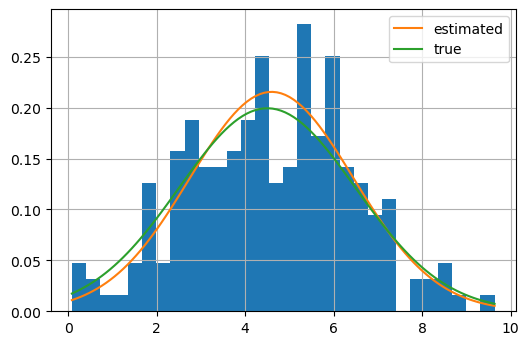

In [3]:
from scipy.stats import norm

# założmy rozkład normalny z mu=4.5 i sigma=2
mu = 4.5
sigma = 2
dist = norm(loc=mu, scale=sigma)

# wylosujmy (zaszumione) 200 przykładów z tego rozkładu
n = 200
noise = np.random.normal(loc=0, scale=0.05, size=n)
samples = dist.rvs(size=n) + noise

# oszacujmy momenty 
empirical_mean = samples.mean()
empircal_std = samples.std()

# zwizualizujmy próbkę za pomocą histogramu
plt.hist(samples, bins=30, density=True)

# zwizualizujmy funkcje gęstości oszacowanego i prawdziwego rozkładu
x = np.linspace(samples.min(), samples.max(), 100)
plt.plot(x, norm.pdf(x, loc=empirical_mean, scale=empircal_std), label='estimated')
plt.plot(x, norm.pdf(x, loc=mu, scale=sigma), label='true')
plt.legend()

## Zadanie 1.

Oszacuj parametr $\lambda$ dla poniższej próbki z rozkładu wykładniczego wykorzystując zależność parametru $\lambda$ i średniej z próbki. 

$$\lambda = \frac{1}{\bar{x}}$$

Zwizualizuj próbkę oraz gęstości prawdziwego i oszacowanego rozkładu jak w przykładzie powyżej.

In [ ]:
from scipy.stats import expon

# rozkład wykładniczy
lamb = 3
dist = expon(scale=1 / lamb)

# wylosujmy (zaszumione) 200 przykładów z rozkładu
n = 200
noise = np.random.normal(loc=0, scale=0.05, size=n)
samples = dist.rvs(size=n) + noise

# miejsce na twoje rozwiązanie


## MLE - Metoda największej wiarygodności
(Maximum Likelihood Estimation)

Co jednak zrobić jeżeli nie wiemy z jakiego rozkładu pochodzi dana próbka? Dla ustalonej rodziny rozkładów i wybranej wartości parametru tego rozkładu możemy policzyć wartość funkcji wiarygodności. 

$$ \mathcal{L}_{\text{MLE}}(\mathbf{X}, \phi) = \prod_{x \in \mathbf{X}} f(x_i, \phi)$$

gdzie $\phi$ to dana wartość parametru, a $f$ funkcja gęstości danego rozkładu.

Następnie używając gotowych funkcji do optymalizacji możemy znaleźć najbardziej "wiarygodną" wartość tego parametru - dla niej funkcja wiarygodności będzie przyjmowała największą wartość.

$$ \phi^* = {\arg\max}_{\phi}  \mathcal{L}_{\text{MLE}}(\mathbf{X}, \phi) $$



### Przykład
Poniżej znajduje się przykład znalezienia parametru $\sigma$ rozkładu normalnego za pomocą metody MLE przy znanej średniej $\mu = 0$. Zastosujemy tutaj tzw. *log-trick*, ponieważ mnożenie wielu prawdopodobieństw daje bardzo małe liczby - bliskie dokładności floata - zamienimy mnożenie na sumowanie logarytmów. Jest to na tyle popularny trik, że `scipy.stats` udostępnia dla rozkładów metodę `logpdf` zwracającą od razu logarytm funkcji gęstości.

$$ \mathcal{L}_{\text{log-MLE}}(\mathbf{X}, \phi) = \sum_{x \in \mathbf{X}} \log f(x_i, \phi)$$

Dodatkowo, ponieważ łatwiej jest numerycznie minimalizować niż maksymalizować zadane funkcje, zamienimy naszą funkcję *celu* na funkcję *kosztu* dodając minus przed wszystkim.

$$ \phi^* = {\arg\min}_{\phi}  -\mathcal{L}_{\text{log-MLE}}(\mathbf{X}, \phi) $$

W ten sposób otrzymaliśmy tzw. funkcję *negative log-likelihood* (NLL) bardzo częstą używaną w uczeniu maszynowym.

Do rozwiązania użyjemy gotowego rozwiązania do szukania minimum [`scipy.optimize.minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html), która przyjmuje jednoargumentową funkcje do optymalizacji i startową wartość szukanego parametru.

In [ ]:
from scipy.optimize import minimize

# założmy rozkład normalny
mu = 0
sigma = 1.75
dist = norm(loc=mu, scale=sigma)

# wylosujmy (zaszumione) 200 przykładów z rozkładu
n = 200
noise = np.random.normal(loc=0, scale=0.05)
data = dist.rvs(size=n) + noise

# jako, że będziemy używać funkcji `minimize`, musimy dla niej przygotować funckję do optymalizowania,
# która przyjmuje tylko jeden argument - wartość startową szukanego parametru
def neg_log_likelihood(phi):
    return -np.sum(norm.logpdf(data, scale=phi))

# wybierzmy startową wartość szukanego parametru 
init_sigma = 1

# użyjmy funkcji `minimize`
minimize(fun=neg_log_likelihood, x0=init_sigma)

#### Wskazówka
Wynik funkcji `minimize` zależy od wielu czynników, stąd warto uruchamiać ją wiele razy z różnymi wartościami startowymi.

In [ ]:
n_tries = 50
best_nll = np.inf
best_sigma = None 

for i in range(n_tries):
    init_sigma = np.random.uniform(0.5, 5)
    result = minimize(fun=neg_log_likelihood, x0=init_sigma)
    
    if result.fun < best_nll:
        best_nll = result.fun
        best_sigma = result.x
        
print(f"Znalazłem sigma= {best_sigma} z NLL= {best_nll}")

## Zadanie 2.

W pliku `data.npz` (proszę pamiętać aby ściągnąć go z repozytorium) znajdują się próbki z czterech różnych rozkładów: 
* Wykładniczy [`expon`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html#scipy.stats.expon) z parametrem $\lambda$ (w kodzie `scale=1 / lamb`),
* Gamma [`gamma`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html#scipy.stats.gamma) z parametrem $a$,
* Pół-normalny [`halfnorm`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.halfnorm.html#scipy.stats.halfnorm) z parametrem $\sigma$ (w kodzie `scale=sigma`)
* Pół-logistyczny [`halflogistic`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.halflogistic.html#scipy.stats.halflogistic) z parametrem $\alpha$ (w kodzie `scale=alpha`)

a) Zwizualizować za pomocą histogramu wszystkie cztery próbki. Czy potrafisz z samych wizualizacji odgadnąć z którego rozkładu pochodzi dana próbka?

b) Za pomocą metody MLE (konkretnie NLL) ustalić z którego rozkładu pochodzi dana próbka oraz oszacować wartości parametrów dla każdej z tych próbek. Jako ułatwienie poniżej podane są przedziały, w których rozsądnie jest szukać wartości dla danych parametrów:

* `scale` ($1 / \lambda$) z rozkładu wykładniczego: `[0.1, 1]`
* `a` z rozkładu Gamma: `[0.5, 6]`
* `scale` ($\sigma$) z rozkładu pół-normalnego: `[0.5, 10]`
* `scale` ($\alpha$) z rozkładu pół-logistycznego: `[0.5, 6]`

In [ ]:
from scipy.stats import expon, gamma, halfnorm, halflogistic

data = np.load('data.npz')

print(list(data.keys()))

data_1 = data['data_1']
data_2 = data['data_2']
data_3 = data['data_3']
data_4 = data['data_4']

print(f"Rozmiar próbki `data_1`: {data_1.shape}")

In [ ]:
# a) histogramy próbek

In [ ]:
# b) oszacowanie rozkładów i ich parametrów